# Rediscovering Factors For Single Stock
Using data to discover hidden factors for price movements

## Getting SPY Data

In [116]:
import yfinance as yf

spy_data = yf.download('SPY')
spy_data = spy_data[['Adj Close']]
spy_returns = spy_data.pct_change().dropna().rename(columns={'Adj Close':'SPY'})
spy_returns.head(3)

[*********************100%***********************]  1 of 1 completed


,SPY
Date,
1993-02-01,0.007113
1993-02-02,0.002118
1993-02-03,0.010571


## Convert to Monthly Returns

,SPY
Date,
1993-03-31,0.022399
1993-04-30,-0.025588
1993-05-31,0.026969
1993-06-30,0.003608
1993-07-31,-0.004855
...,...
2022-08-31,-0.040802
2022-09-30,-0.092446
2022-10-31,0.081276


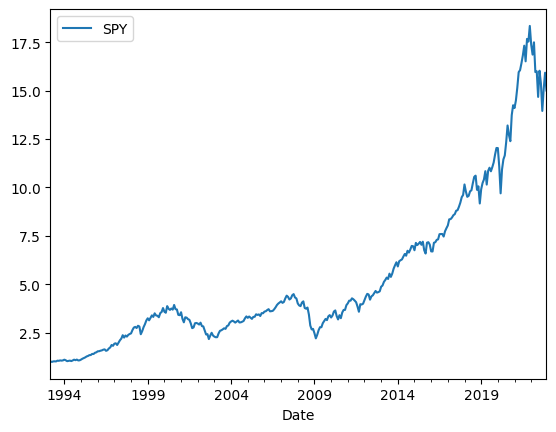

In [117]:
spy_monthly_returns = spy_returns.copy().add(1)
spy_monthly_returns = spy_monthly_returns.resample('1M').prod().add(-1).iloc[1:-1]
spy_monthly_returns.add(1).cumprod().plot()
spy_monthly_returns

## Create Features

In [172]:
import numpy as np
import pandas as pd

# use only monthly returns as features
def generate_data_monthly(ret, lookback_months=12, verbose=True):
    data_all = np.lib.stride_tricks.sliding_window_view(ret.values.flatten(),lookback_months+1)
    data_x = data_all[:,:-1]
    data_y = data_all[:,-1:]
    data_x_labels = [f'Ret_M_{x+1}' for x in range(data_x.shape[1])[::-1]]
    if verbose:
        print(f'data_x has shape {data_x.shape}')
        print(f'data_y has shape {data_y.shape}')
        print(data_x_labels)
    return data_x, data_y, data_x_labels

In [173]:
# generate monthly and quarterly features
def generate_data_monthly_quarterly(ret, lookback_months=12, verbose=True):
    data_x, data_y, data_x_labels = generate_data_monthly(ret=ret, lookback_months=lookback_months, verbose=False)
    num_months = data_x.shape[1]
    num_quarters = num_months // 3
    if num_quarters > 0:
        months_leftover = num_months % 3
        data_x_truncated = data_x[:,months_leftover:]
        for quarter in range(num_quarters):
            _temp_quarter_data = np.prod(data_x_truncated[:,(quarter*3):(quarter+1)*3] + 1, axis=1) - 1
            data_x = np.concatenate((data_x, _temp_quarter_data[:,np.newaxis]), axis=1)

        data_x_labels = data_x_labels + [f'Ret_Q_{x+1}' for x in range(num_quarters)[::-1]]
    if verbose:
        print(f'data_x has shape {data_x.shape}')
        print(f'data_y has shape {data_y.shape}')
        print(data_x_labels)
    
    return data_x, data_y, data_x_labels

## Pick Best Month/Quarter To Predict Up/Down
Target Accuracy

In [174]:
data_x, data_y, data_x_labels = generate_data_monthly_quarterly(ret=spy_monthly_returns,lookback_months=12)

data_x has shape (346, 16)
data_y has shape (346, 1)
['Ret_M_12', 'Ret_M_11', 'Ret_M_10', 'Ret_M_9', 'Ret_M_8', 'Ret_M_7', 'Ret_M_6', 'Ret_M_5', 'Ret_M_4', 'Ret_M_3', 'Ret_M_2', 'Ret_M_1', 'Ret_Q_4', 'Ret_Q_3', 'Ret_Q_2', 'Ret_Q_1']


In [233]:
import seaborn as sns
num_samples, num_features = data_x.shape

data_x_sign = np.sign(data_x)
data_y_sign = np.sign(data_y)

output_data = {}
# benchmark, predicting all up (buy and hold)
output_data['Accuracy']= [np.sum(data_y_sign == 1) / num_samples]
benchmark_mean = data_y.mean() * 12
benchmark_vol = data_y.std() * np.sqrt(12)
output_data['Vol'] = [benchmark_vol]
output_data['Mean'] = [benchmark_mean]
output_data['Sharpe'] = [benchmark_mean / benchmark_vol]

cum_returns_data = pd.DataFrame({
    'Benchmark (All Up)': np.cumprod(np.insert(data_y.flatten(),0,0) + 1),
}, index=spy_monthly_returns.index[11:])
cum_hit_data = pd.DataFrame({
    'Benchmark (All Up)': np.cumsum(np.insert(data_y_sign.flatten(),0,0)),
}, index=spy_monthly_returns.index[11:])

for feature_i in range(num_features):
    correct_count = np.sum(data_x_sign[:,feature_i] == data_y_sign.flatten())
    feature_i_accuracy = correct_count / num_samples
    output_data['Accuracy'].append(feature_i_accuracy)
    strategy_returns = data_y.flatten() * data_x_sign[:,feature_i]
    feature_i_vol = np.std(strategy_returns) * np.sqrt(12)
    feature_i_mean = np.mean(strategy_returns) * 12
    output_data['Vol'].append(feature_i_vol)
    output_data['Mean'].append(feature_i_mean)
    output_data['Sharpe'].append(feature_i_mean / feature_i_vol)
    
    cum_returns_data = pd.concat([
        cum_returns_data,
        pd.DataFrame({
            data_x_labels[feature_i]: np.cumprod(np.insert(strategy_returns,0,0) + 1),
        }, index=spy_monthly_returns.index[11:])
    ], axis=1)
    
    cum_hit_data = pd.concat([
        cum_hit_data,
        pd.DataFrame({
            data_x_labels[feature_i]: np.cumsum(np.insert(data_x_sign[:,feature_i] * data_y_sign.flatten(),0,0)),
        }, index=spy_monthly_returns.index[11:])
    ], axis=1)
    
    

accuracy_score_df = pd.DataFrame(output_data, index = ['Benchmark (All Up)']  + data_x_labels)
pd.options.display.float_format = '{:,.2f}'.format
accuracy_score_df



,Accuracy,Vol,Mean,Sharpe
Benchmark (All Up),0.65,0.15,0.10,0.68
Ret_M_12,0.57,0.15,0.06,0.39
Ret_M_11,0.58,0.15,0.06,0.37
Ret_M_10,0.55,0.15,0.06,0.42
Ret_M_9,0.59,0.15,0.04,0.29
Ret_M_8,0.61,0.15,0.07,0.44
Ret_M_7,0.61,0.15,0.12,0.78
Ret_M_6,0.54,0.15,0.01,0.07
Ret_M_5,0.58,0.15,0.05,0.32
Ret_M_4,0.54,0.15,0.03,0.17


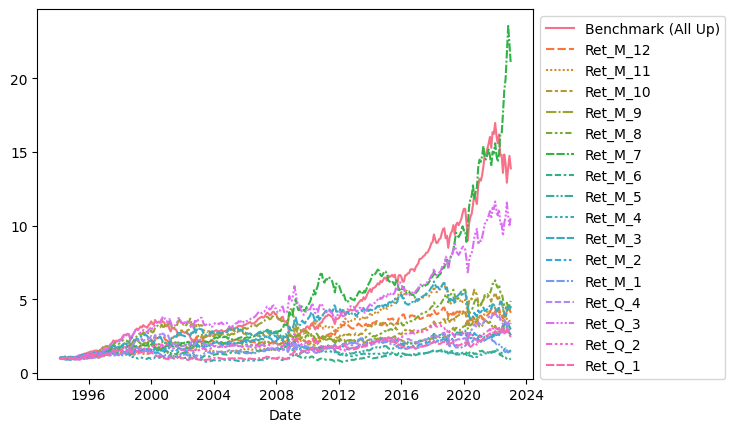

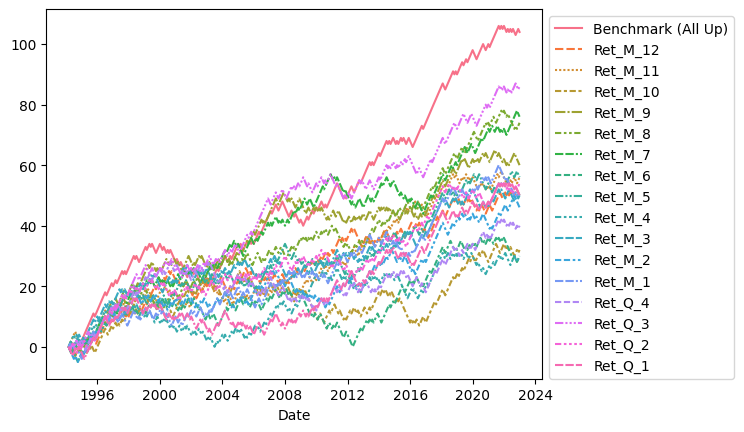

In [242]:
import matplotlib.pyplot as plt
ax = sns.lineplot(cum_returns_data)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
ax = sns.lineplot(cum_hit_data)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [232]:
cum_hit_data

,Benchmark (All Up),Ret_M_12,Ret_M_11,Ret_M_10,Ret_M_9,Ret_M_8,Ret_M_7,Ret_M_6,Ret_M_5,Ret_M_4,Ret_M_3,Ret_M_2,Ret_M_1,Ret_Q_4,Ret_Q_3,Ret_Q_2,Ret_Q_1
Date,,,,,,,,,,,,,,,,,
1994-02-28,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1994-03-31,-1.00,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0
1994-04-30,0.00,0,2,1,0,2,0,2,0,2,1,0,1,1,1,1,0
1994-05-31,1.00,1,3,1,1,2,1,2,1,3,1,0,2,2,2,2,0
1994-06-30,0.00,1,4,1,2,2,2,2,1,4,2,0,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,104.00,196,199,186,203,207,209,186,199,186,195,196,196,191,214,197,197
2022-09-30,103.00,197,199,187,203,208,210,186,200,186,196,196,197,191,215,198,198
2022-10-31,104.00,198,199,188,203,208,211,186,201,186,197,196,197,192,215,198,198


In [218]:
cum_returns_data['Ret_M_7'].tail(20)

Date
2021-05-31   14.49
2021-06-30   14.81
2021-07-31   15.17
2021-08-31   14.72
2021-09-30   14.04
2021-10-31   15.02
2021-11-30   14.90
2021-12-31   15.59
2022-01-31   14.77
2022-02-28   14.33
2022-03-31   14.87
2022-04-30   16.18
2022-05-31   16.21
2022-06-30   17.55
2022-07-31   19.17
2022-08-31   19.95
2022-09-30   21.79
2022-10-31   23.56
2022-11-30   22.25
2022-12-31   20.97
Freq: M, Name: Ret_M_7, dtype: float64

In [225]:
np.cumprod(data_x_sign[:,5] * data_y.flatten() + 1)[-10:]

array([14.87059983, 16.17577787, 16.21229128, 17.54916435, 19.16522251,
       19.94720111, 21.79123837, 23.56233361, 22.25246789, 20.97009811])

In [226]:
data_y.flatten()[-10:]

array([ 0.03759038, -0.08776902,  0.00225729, -0.08246046,  0.09208747,
       -0.04080196, -0.09244592,  0.08127557,  0.05559151, -0.05762821])

17.549164276602788